# Задание 5.2 - Word2Vec with Negative Sampling

В этом задании мы натренируем свои версию word vectors с negative sampling на том же небольшом датасете.

Перед запуском нужно запустить скрипт `download_data.sh`, чтобы скачать данные.

Датасет и модель очень небольшие, поэтому это задание можно выполнить и без GPU.

In [0]:
!bash download_data.sh
!pip install -r requirements.txt

In [0]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torchvision import transforms

from dataset import StanfordTreeBank, Word2VecNegativeSampling
from model import Word2VecNegativeSamples
from visualize import extract_word_vectors, visualize_vectors
from train import train_neg_sample

import matplotlib.pyplot as plt
%matplotlib inline

device = torch.device("cuda:0")

In [0]:
data = StanfordTreeBank()
data.load_dataset("./stanfordSentimentTreebank/")

print("Num tokens:", data.num_tokens())
for i in range(5):
    center_word, other_words = data.get_random_context(5)
    print(center_word, other_words)

Num tokens: 19538
stories ['challenge', 'new', 'centuries']
pieces ['superbly', 'likes', 'mainstream']
90 ['fluff', 'drifts', 'lodging', 'in']
lacking ['elegance', 'maturity']
moore ['migraine-inducing', 'spoon', 'feeding']


# Dataset для Negative Sampling должен быть немного другим

Как и прежде, Dataset должен сгенерировать много случайных контекстов и превратить их в сэмплы для тренировки.

Здесь мы реализуем прямой проход модели сами, поэтому выдавать данные можно в удобном нам виде.
Напоминаем, что в случае negative sampling каждым сэмплом является:
- вход: слово в one-hot представлении
- выход: набор из одного целевого слова и K других случайных слов из словаря.
Вместо softmax + cross-entropy loss, сеть обучается через binary cross-entropy loss - то есть, предсказывает набор бинарных переменных, для каждой из которых функция ошибки считается независимо.

Для целевого слова бинарное предсказание должно быть позитивным, а для K случайных слов - негативным.

Из набора слово-контекст создается N сэмплов (где N - количество слов в контексте), в каждом из них K+1 целевых слов, для только одного из которых предсказание должно быть позитивным.
Например, для K=2:

Слово: `orders` и контекст: `['love', 'nicest', 'to', '50-year']` создадут 4 сэмпла:
- input: `orders`, target: `[love: 1, any: 0, rose: 0]`
- input: `orders`, target: `[nicest: 1, fool: 0, grass: 0]`
- input: `orders`, target: `[to: 1, -: 0, the: 0]`
- input: `orders`, target: `[50-year: 1, ?: 0, door: 0]`

Все слова на входе и на выходе закодированы через one-hot encoding, с размером вектора равным количеству токенов.

In [0]:
num_negative_samples = 10

dataset = Word2VecNegativeSampling(data, num_negative_samples, 10)
dataset.generate_dataset()
input_index, output_indices, output_target = dataset[0]

print("Sample - input: %s, output indices: %s, output target: %s" % (input_index, output_indices, output_target))
assert isinstance(output_indices, torch.Tensor)
assert output_indices.shape[0] == num_negative_samples+1

assert isinstance(output_target, torch.Tensor)
assert output_target.shape[0] == num_negative_samples+1
assert torch.sum(output_target) == 1.0

Sample - input: 5593, output indices: tensor([ 5591, 13769, 18715, 17773,  4251,  5013, 15839, 17607,  2390, 16315,
         4385]), output target: tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])


# Создаем модель

Для нашей задачи нам придется реализовать свою собственную PyTorch модель.
Эта модель реализует свой собственный прямой проход (forward pass), который получает на вход индекс входного слова и набор индексов для выходных слов. 

Как всегда, на вход приходит не один сэмпл, а целый batch.

In [0]:
dataset = Word2VecNegativeSampling(data, num_negative_samples, 30000)
dataset.generate_dataset()
len(dataset)

82771

In [0]:
wordvec_dim = 10
          
nn_model = Word2VecNegativeSamples(data.num_tokens(), wordvec_dim)
nn_model.to(device)

Word2VecNegativeSamples(
  (input): Linear(in_features=19538, out_features=10, bias=False)
  (output): Linear(in_features=10, out_features=19538, bias=False)
)

In [0]:
untrained_input_vectors, untrained_output_vectors = extract_word_vectors(nn_model)
assert untrained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert untrained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

# Ну и наконец тренировка!

Добейтесь значения ошибки меньше **0.25**.

In [0]:
loss = nn.BCEWithLogitsLoss()
optimizer = optim.SGD(nn_model.parameters(), lr=2, weight_decay=0, nesterov=True, momentum=.9)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, factor=.1**(1/3), patience=3, threshold=1e-2, verbose=True)

loss_history, train_history = train_neg_sample(nn_model, device, dataset, loss, optimizer, scheduler, 100)
#Epoch 100, Average loss: 0.172043, Train accuracy: 0.393543

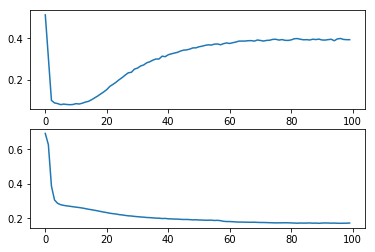

In [9]:
plt.subplot(211)
plt.plot(train_history)
plt.subplot(212)
plt.plot(loss_history);

# Визуализируем вектора для разного вида слов до и после тренировки

Как и ранее, в случае успешной тренировки вы должны увидеть как вектора слов разных типов (например, знаков препинания, предлогов и остальных)

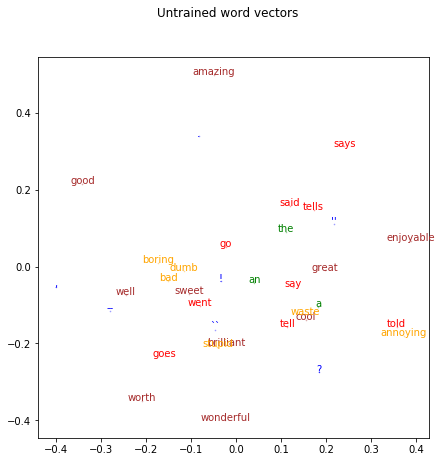

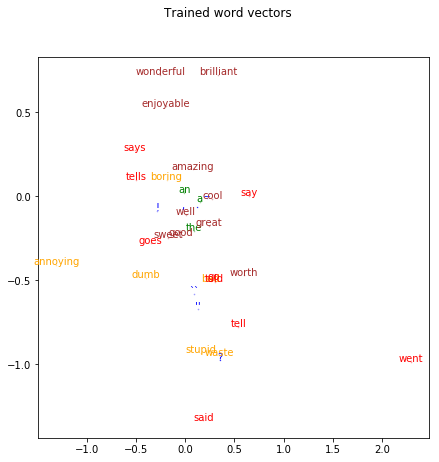

In [28]:
trained_input_vectors, trained_output_vectors = extract_word_vectors(nn_model)
assert trained_input_vectors.shape == (data.num_tokens(), wordvec_dim)
assert trained_output_vectors.shape == (data.num_tokens(), wordvec_dim)

visualize_vectors(data, untrained_input_vectors, untrained_output_vectors, 'cat', plt, "Untrained word vectors")
visualize_vectors(data, trained_input_vectors, trained_output_vectors, 'cat', plt, "Trained word vectors")

In [0]:
full_vectors = trained_input_vectors + trained_output_vectors
def similarity(w1, w2):
    a = (full_vectors[data.index_by_token[w1[0]]] - full_vectors[data.index_by_token[w1[1]]]).reshape((1, -1))
    b = (full_vectors[data.index_by_token[w2[0]]] - full_vectors[data.index_by_token[w2[1]]]).reshape((1, -1))
    cos = nn.modules.distance.CosineSimilarity()
    return torch.norm(a), torch.norm(b), cos(a, b)